# 5.Binary Rural Model Tuning and Implementation

This notebook demonstrates the process of fine-tuning and implementing the best algorithm identified for binary class modeling (XGB) for the rural area. Resampling was explored as an attempt to improve model performance, though was not implemented for the final model due to its less than ideal performance. 

<a id='sections'></a>
**Sections**
- [**5.Binary Rural Model Tuning and Implementation**](#binary-rural-model-tuning-and-implementation)
    - [Examine the Distribution of Training Data](#examine-the-distribution-of-training-data)
    - [Comparing Machine Learning Algorithms](#comparing-machine-learning-algorithms)
        - Logistic Regression
        - Support Vector Machine
        - Random Forest
        - XGBoost
        - Conclusion
    - [Discovering the Best Model with the Selected Algorithm (XGBoost)](#discovering-the-best-model-with-the-selected-algorithm)
    - [Resampling](#resampling)
        - [Evaluating Oversampling Strategies](#evaluating-oversampling-strategies)
            - SMOTE
            - Random Oversample
        - [Evaluateing the Effect of Sampling by Roadway Functional Class](#evaluating-the-effect-of-sampling-by-roadway-functional-class)
            - Oversampling
            - Downsampling
            - Oversampling + Downsampling 
            - Conclusion
    - [Final Model](#final-model)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
from numpy import argmax
import importlib
import collections
import time
import getpass
import datetime as datetime
from shapely import wkt
from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer,  LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, brier_score_loss, auc
from sklearn.metrics import f1_score, fbeta_score, confusion_matrix, make_scorer, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import  StratifiedKFold, KFold, cross_val_score, StratifiedShuffleSplit
from sklearn.model_selection import  RepeatedStratifiedKFold, GridSearchCV, cross_validate

from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from varname import nameof

In [2]:
# import modules
import sys; sys.path.insert(0, '../..')
from src import models
from src.models import *
# importlib.reload (src.models)
from src.data_preprocessing import geo_segmentid

Using TensorFlow backend.


In [3]:
base_gis_dir  = "G:/CUUATS/Safety Forecasting Tool/"
base_file_dir = "L:/Safety Forecasting Tool/"
base_tool_dir = "L:/Safety_Crash Data Analysis/"

In [4]:
with open(base_file_dir+'data/processed/df_rural_train_2014_2017.pkl', 'rb') as f:
    df_rural_train = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_train_label_2014_2017.pkl', 'rb') as f:
    df_rural_train_label = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_test_2018.pkl', 'rb') as f:
    df_rural_test = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_test_label_2018.pkl', 'rb') as f:
    df_rural_test_label = pickle.load(f)

In [5]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def precision(y_true, y_pred): return precision_score(y_true, y_pred)
def recall(y_true, y_pred): return recall_score(y_true, y_pred)
def fbeta_2(y_true,y_pred,beta=2.0): return fbeta_score(y_true, y_pred, beta=2.0)

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn),
           'precision':make_scorer(precision),'recall':make_scorer(recall),
           'fbeta_2':make_scorer(fbeta_2)}

In [6]:
# Remove features that should not be fed into the model
remove_list=['segment_id','overlap','geometry','Year']
targetlist = [i for i in list(df_rural_train.columns) if i not in remove_list]
df_rural_train_sub = df_rural_train[targetlist]
df_rural_test_sub = df_rural_test[targetlist]

In [7]:
# Convert full training & testing data to binary class categories
df_rural_train_bi_label = df_rural_train_label.mask(df_rural_train_label >=2, 1)
df_rural_test_bi_label=df_rural_test_label.mask(df_rural_test_label >= 2, 1)

In [8]:
X_train=df_rural_train_sub
y_train=df_rural_train_bi_label
X_test=df_rural_test_sub
y_test=df_rural_test_bi_label

X_train_OHtransformed=func_OHtransform_var(X_train)
OHfname = func_OHtransformed_var(X_train)
X_test_OHtransformed=func_OHtransform_var(X_test)

# Examining the Distribution of Training Data
<a id='examing-the-distribution-of-training-data'></a>
[[back to top](#sections)]

The distribution of the input data (training data) is examined at the very first step.

In [9]:
# Number of positive samples and negtive samples
pos_neg_counts = df_rural_train_sub.copy()
pos_neg_counts['y'] = df_rural_train_bi_label
pos_neg_counts.groupby(['functional_classification','y']).size()

functional_classification  y  
Interstate                 0.0      167
                           1.0      245
Local Road or Street       0.0    17496
                           1.0      680
Major Arterial             0.0      155
                           1.0      109
Major Collector            0.0     2236
                           1.0      448
Minor Arterial             0.0      480
                           1.0      172
Minor Collector            0.0      511
                           1.0       37
dtype: int64

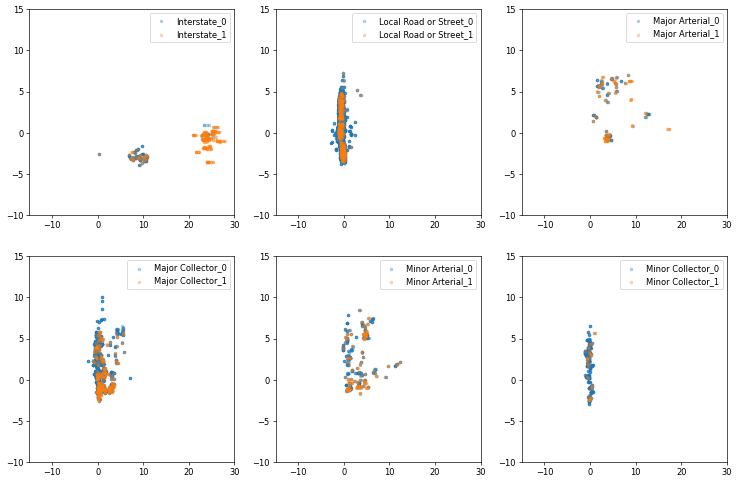

In [10]:
# Distribution of each roadway functional class in linear reduced dimension
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_OHtransformed_pca = pca.fit_transform(X_train_OHtransformed)
place_dict = dict({'Interstate':(0,0), 'Local Road or Street':(0,1), 'Major Arterial':(0,2),
                   'Major Collector':(1,0), 'Minor Arterial':(1,1), 'Minor Collector':(1,2)})
fig,ax=plt.subplots(2,3,figsize=(15,10),dpi=60)
for i,rdclass in enumerate(['Interstate', 'Local Road or Street', 'Major Arterial','Major Collector', 'Minor Arterial', 'Minor Collector']):
    df_X = X_train_OHtransformed_pca[df_rural_train_sub['functional_classification']==rdclass]
    df_y = df_rural_train_bi_label[df_rural_train_sub['functional_classification']==rdclass]
    ax[place_dict[rdclass]].scatter(df_X[df_y==0][:,0],df_X[df_y==0][:,1],label=rdclass+'_0',s=10,alpha=0.3)
    ax[place_dict[rdclass]].scatter(df_X[df_y==1][:,0],df_X[df_y==1][:,1],label=rdclass+'_1',s=10,alpha=0.3)
    ax[place_dict[rdclass]].set_xlim((-15,30))
    ax[place_dict[rdclass]].set_ylim((-10,15))
    ax[place_dict[rdclass]].legend()

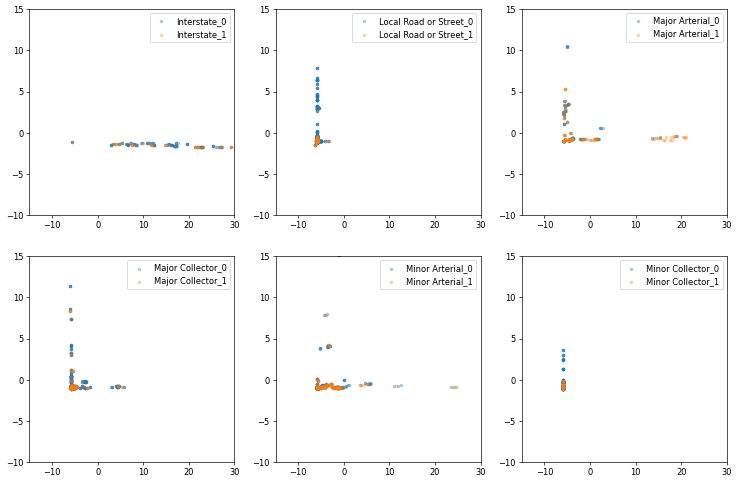

In [21]:
# Distribution of each roadway functional class in non-linear reduced dimension
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='poly',  gamma=0.1)
X_train_OHtransformed_pca = pca.fit_transform(X_train_OHtransformed)
place_dict = dict({'Interstate':(0,0), 'Local Road or Street':(0,1), 'Major Arterial':(0,2),
                   'Major Collector':(1,0), 'Minor Arterial':(1,1), 'Minor Collector':(1,2)})
fig,ax=plt.subplots(2,3,figsize=(15,10),dpi=60)
for i,rdclass in enumerate(['Interstate', 'Local Road or Street', 'Major Arterial','Major Collector', 'Minor Arterial', 'Minor Collector']):
    df_X = X_train_OHtransformed_pca[df_rural_train_sub['functional_classification']==rdclass]
    df_y = df_rural_train_bi_label[df_rural_train_sub['functional_classification']==rdclass]
    ax[place_dict[rdclass]].scatter(df_X[df_y==0][:,0],df_X[df_y==0][:,1],label=rdclass+'_0',s=10,alpha=0.3)
    ax[place_dict[rdclass]].scatter(df_X[df_y==1][:,0],df_X[df_y==1][:,1],label=rdclass+'_1',s=10,alpha=0.3)
    ax[place_dict[rdclass]].set_xlim((-15,30))
    ax[place_dict[rdclass]].set_ylim((-10,15))
    ax[place_dict[rdclass]].legend()

**Findings:**
- The dataset is very imbalanced between positive and negative classes.
- The charts above show that separating the positive class and negative by functional class using either linear or non-linear (polynomial) dimension reduction is challenging, with much overlap between the positive and negative class spaces observed under both principle component analysis method.

# Comparing Machine Learning Algorithms 
<a id='comparing-machine-learning-algorithms'></a>
[[back to top](#sections)]

- 4 machine learning algorithms are tested in this study 
    - (i) Logistic regression 
    - (ii) Support Vector Machine (SVC)
    - (iii) Random Forest 
    - (iv) eXtreme Gradient Boosting (XGBoost)
- The hyperparameter tuning process of SVC,Random Forest, and XGBoost are conducted on AWS EC2. 
- The model performance evaluation is based on the f2 score.

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

Time needed for training the model:  2.5 seconds
No Skill Model PR AUC: 0.087
Model PR AUC: 0.436
From Training data:
Best Threshold=0.082496, precision=0.256, recall=0.661, F2_Score=0.502


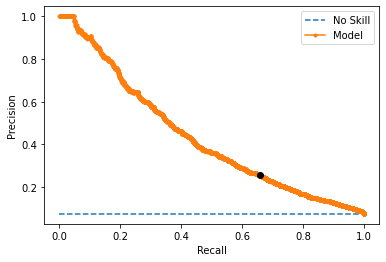

Results of testing data:
          pred_neg  pred_pos
true_neg      4456       817
true_pos       144       267


In [12]:
sampling=None
LRmodel=LogisticRegression(solver='lbfgs', max_iter=1000)
t0 = time.time()
LRmodel_fitted=LRmodel.fit(X_train_OHtransformed, y_train)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed, y_train, X_test_OHtransformed, y_test, LRmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg        10        31
true_pos         2        60
Local Road or Street
          pred_neg  pred_pos
true_neg      4134       245
true_pos       122        43
Major Arterial
          pred_neg  pred_pos
true_neg         0        40
true_pos         0        26
Major Collector
          pred_neg  pred_pos
true_neg       200       369
true_pos        10        92
Minor Arterial
          pred_neg  pred_pos
true_neg        19       103
true_pos         1        40
Minor Collector
          pred_neg  pred_pos
true_neg        93        29
true_pos         9         6
Overall
          pred_neg  pred_pos
true_neg      4456       817
true_pos       144       267
F2score: 0.49 Precision: 0.25 Recall: 0.65 Fpr: 0.15


f2score precision recall   fpr
Interstate              0.88      0.66   0.97  0.76
Local Road or Street    0.23      0.15   0.26  0.06
Major Arterial          0.76      0.39    1.0   1.0
Major Collector         0.53       0.2    0.9  0.65
Minor Arterial          0.65      0.28   0.98  0.84
Minor Collector         0.32      0.17    0.4  0.24
Overall                 0.49      0.25   0.65  0.15

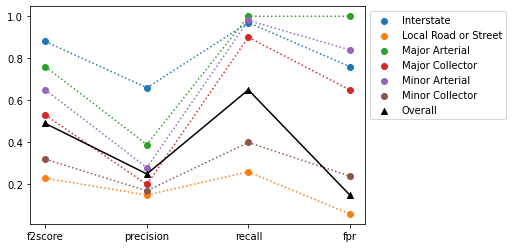

In [13]:
best_thres = model_results[1]
y_test_pred = LRmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
cfm_fc_df = cfm_fc(X_test, y_test, y_test_pred_adj)
cfm_fc_df

## Support Vector Machine

In [14]:
from sklearn.svm import SVC

Hyperparamater tuning range:
- kernel: ['linear', 'poly','rbf']
- class_weight: [{1:1},{1:2},{1:3}]

In [15]:
# SVC model tuning enabled by AWS_EC2_BinaryRural_SVC.py
with open(base_file_dir+'data/AWS Tuning results/BinaryRural_SVC_search_results_old.pkl', 'rb') as f:
    BinaryRural_SVC_search_results = pickle.load(f)

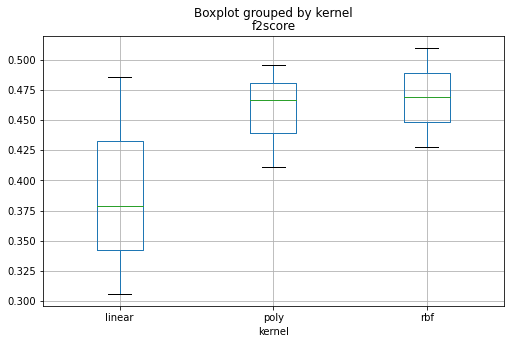

In [16]:
# An overview of the results of the model tuning executed on AWS EC2
BinaryRural_SVC_search_results.boxplot(column=['f2score'],by='kernel',figsize=(8,5))

In [17]:
BinaryRural_SVC_search_results.sort_values(by='f2score',ascending=False).head(5)

kernel class_weight  threshold  precision    recall   f1score   f2score  \
8     rbf       {1: 3}   0.052549   0.328378  0.591241  0.422242  0.509648   
5    poly       {1: 3}   0.056935   0.335756  0.562044  0.420382  0.495283   
2  linear       {1: 3}   0.057712   0.240575  0.652068  0.351475  0.485859   
4    poly       {1: 2}   0.059687   0.318649  0.527981  0.397436  0.466667   
6     rbf       {1: 1}   0.061244   0.299392  0.479319  0.368569  0.427889   

         time  
8  189.748024  
5  154.234854  
2  745.904027  
4  128.728764  
6  117.500978

It can be observed from the boxplot and the table that:
- (1) For this study, 'rbf' kernel is better than the linear kernel and the poly kernel.
- (2) The best model found by SVC has a close performance to the Logistic Regression model. However, It requires much more time to train a SVC model than the Logistic Regression model, which is not for updating the model with new data resources in the future. 

Time needed for training the model:  211.91 seconds
No Skill Model PR AUC: 0.096
Model PR AUC: 0.452
From Training data:
Best Threshold=0.049476, precision=0.305, recall=0.703, F2_Score=0.558


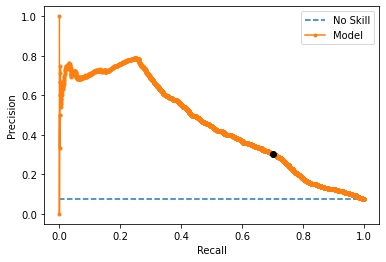

Results of testing data:
          pred_neg  pred_pos
true_neg      4545       728
true_pos       152       259


In [18]:
sampling=None
Bestparam = zip(list(BinaryRural_SVC_search_results.sort_values(by=['f2score'],ascending=False).head(1).columns), 
              BinaryRural_SVC_search_results.sort_values(by=['f2score'],ascending=False).head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
SVCmodel=SVC(random_state = 42,probability=True,
            kernel=BestparamDict['kernel'],class_weight=BestparamDict['class_weight'])
t0 = time.time()
SVCmodel_fitted=SVCmodel.fit(X_train_OHtransformed, y_train)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results = binary_summary_report (X_train_OHtransformed, y_train, X_test_OHtransformed, y_test, SVCmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg        12        29
true_pos         2        60
Local Road or Street
          pred_neg  pred_pos
true_neg      4126       253
true_pos       116        49
Major Arterial
          pred_neg  pred_pos
true_neg         3        37
true_pos         1        25
Major Collector
          pred_neg  pred_pos
true_neg       274       295
true_pos        21        81
Minor Arterial
          pred_neg  pred_pos
true_neg        32        90
true_pos         3        38
Minor Collector
          pred_neg  pred_pos
true_neg        98        24
true_pos         9         6
Overall
          pred_neg  pred_pos
true_neg      4545       728
true_pos       152       259
F2score: 0.49 Precision: 0.26 Recall: 0.63 Fpr: 0.14


f2score precision recall   fpr
Interstate              0.89      0.67   0.97  0.71
Local Road or Street    0.25      0.16    0.3  0.06
Major Arterial          0.75       0.4   0.96  0.92
Major Collector         0.52      0.22   0.79  0.52
Minor Arterial          0.65       0.3   0.93  0.74
Minor Collector         0.33       0.2    0.4   0.2
Overall                 0.49      0.26   0.63  0.14

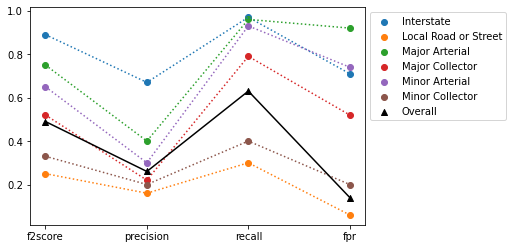

In [19]:
best_thres = model_results[1]
y_test_pred = SVCmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
cfm_fc_df = cfm_fc(X_test, y_test, y_test_pred_adj)
cfm_fc_df

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

range:
- n_estimators: [5,10,25,50,100,200, 300, 500, 1000, 1500, 2000,3000,4000,5000]
- max_depth: [3,4,5,6,7,8]
- max_features: [3,4,5,6,7,8]
- min_samples_split: [0.2,0.4,0.6,0.8,0.9]

In [21]:
# Random Forest model tuning enabled by AWS_EC2_BinaryRural_RF.py
with open(base_file_dir+'data/AWS Tuning results/BinaryRural_RF_search_results.pkl', 'rb') as f:
    BinaryRural_RF_search_results = pickle.load(f)

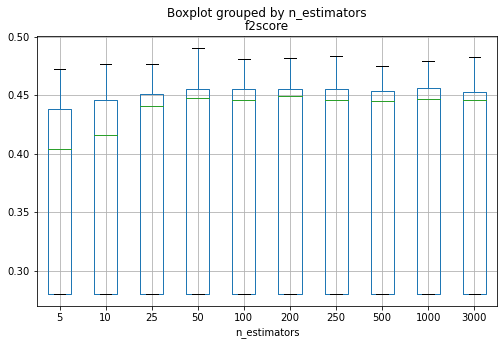

In [22]:
# An overview of the results of the model tuning executed on AWS EC2
BinaryRural_RF_search_results.boxplot(column=['f2score'],by='n_estimators',figsize=(8,5))

From the boxplot, it can be concluded that the range of f2 score returned by the Random Forest algorithm is from 0.27 to 0.48.

In [23]:
# Top 10 best Random Forest models
BinaryRural_RF_search_results.sort_values(by=['f2score'],ascending=False).head(5)

n_estimators  max_depth  max_features  min_samples_split  threshold  \
595             50          8             7                0.2       0.07   
1045           250          8             7                0.2       0.07   
1490          3000          8             6                0.2       0.07   
880            200          8             4                0.2       0.07   
720            100          7             7                0.2       0.07   

      precision    recall   f1score   f2score       fpr    tn    fp   fn   tp  \
595    0.214440  0.722628  0.330735  0.490261  0.206334  4185  1088  114  297   
1045   0.212364  0.710462  0.326988  0.483604  0.205386  4190  1083  119  292   
1490   0.215789  0.698297  0.329696  0.482515  0.197800  4230  1043  124  287   
880    0.216730  0.693431  0.330243  0.481582  0.195335  4243  1030  126  285   
720    0.215746  0.693431  0.329099  0.480607  0.196473  4237  1036  126  285   

           time  
595    0.246838  
1045   1.068964  
1490  12.308971  
880    0.837884  
720    0.475148

n_estimators= 50 max_depth= 8 max_features= 7 min_samples_split= 0.2
Time needed for training the model:  0.26 seconds
No Skill Model PR AUC: 0.089
Model PR AUC: 0.383
From Training data:
Best Threshold=0.072044, precision=0.219, recall=0.679, F2_Score=0.478


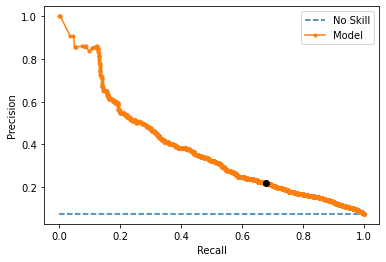

Results of testing data:
          pred_neg  pred_pos
true_neg      4246      1027
true_pos       124       287


In [24]:
sampling=None
Bestparam = zip(list(BinaryRural_RF_search_results.sort_values(by=['f2score'],ascending=False).head(1).columns), 
              BinaryRural_RF_search_results.sort_values(by=['f2score'],ascending=False).head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print('n_estimators=', int(BestparamDict['n_estimators']), 'max_depth=',int(BestparamDict['max_depth']),
    'max_features=',int(BestparamDict['max_features']),'min_samples_split=',BestparamDict['min_samples_split'])

RFmodel=RandomForestClassifier(random_state = 42, n_jobs=-1,
                            n_estimators=int(BestparamDict['n_estimators']), max_depth=int(BestparamDict['max_depth']),
                            max_features=int(BestparamDict['max_features']),min_samples_split=BestparamDict['min_samples_split'])
t0 = time.time()
RFmodel_fitted=RFmodel.fit(X_train_OHtransformed, y_train)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed, y_train, X_test_OHtransformed, y_test, RFmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg         0        41
true_pos         0        62
Local Road or Street
          pred_neg  pred_pos
true_neg      4192       187
true_pos       119        46
Major Arterial
          pred_neg  pred_pos
true_neg         0        40
true_pos         0        26
Major Collector
          pred_neg  pred_pos
true_neg        13       556
true_pos         1       101
Minor Arterial
          pred_neg  pred_pos
true_neg         0       122
true_pos         0        41
Minor Collector
          pred_neg  pred_pos
true_neg        41        81
true_pos         4        11
Overall
          pred_neg  pred_pos
true_neg      4246      1027
true_pos       124       287
F2score: 0.49 Precision: 0.22 Recall: 0.7 Fpr: 0.19


f2score precision recall   fpr
Interstate              0.88       0.6    1.0   1.0
Local Road or Street    0.26       0.2   0.28  0.04
Major Arterial          0.76      0.39    1.0   1.0
Major Collector         0.47      0.15   0.99  0.98
Minor Arterial          0.63      0.25    1.0   1.0
Minor Collector         0.36      0.12   0.73  0.66
Overall                 0.49      0.22    0.7  0.19

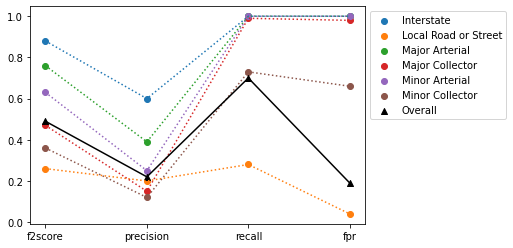

In [25]:
best_thres = model_results[1]
y_test_pred = RFmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
cfm_fc_df = cfm_fc(X_test, y_test, y_test_pred_adj)
cfm_fc_df

## XGBoost

In [26]:
from xgboost import XGBClassifier

Hyperparamater tuning range:
- max_depth in [3,4,5,6,7,8]
- eta: [0.1,0.3,0.5]
- subsample:[0.6,0.8,1]
- min_child_weight: [1,2,3,4,5]
- scale_pos_weight: [1,3,5,7,9]

In [27]:
# XGB model tuning enabled by AWS_EC2_BinaryRural_XGB.py
with open(base_file_dir+'data/AWS Tuning results/BinaryRural_XGB_search_results.pkl', 'rb') as f:
    BinaryRural_XGB_search_results = pickle.load(f)

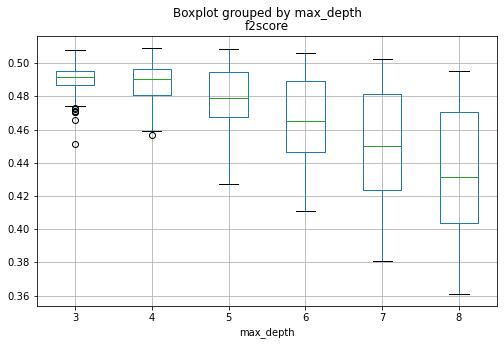

In [28]:
# An overview of the results of the model tuning executed on AWS EC2
BinaryRural_XGB_search_results.boxplot(column=['f2score'],by='max_depth',figsize=(8,5))

BinaryRural_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(5)From the boxplot, it can be concluded that the range of f2 score returned by the XGBoost algorithm varies with max_depth. The average performance of XGBoost is better than the other algorithms. 

In [29]:
BinaryRural_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(5)

max_depth  eta  subample  min_child_weight  scale_pos_weight  threshold  \
292          4  0.1       1.0                 4                 5       0.34   
488          5  0.1       0.8                 3                 7       0.41   
472          5  0.1       0.6                 5                 5       0.38   
297          4  0.1       1.0                 5                 5       0.38   
496          5  0.1       0.8                 5                 3       0.26   

     precision    recall   f1score   f2score       fpr    tn   fp   fn   tp  \
292   0.258669  0.671533  0.373478  0.509037  0.150009  4482  791  135  276   
488   0.253636  0.678832  0.369292  0.508382  0.155699  4452  821  132  279   
472   0.277020  0.642336  0.387097  0.508279  0.130666  4584  689  147  264   
297   0.282162  0.635036  0.390719  0.507980  0.125925  4609  664  150  261   
496   0.271066  0.649635  0.382521  0.507798  0.136165  4555  718  144  267   

         time  
292  0.573293  
488  0.784312  
472  0.838070  
297  0.579429  
496  0.786016

max_depth= 4 eta= 0.1 subsample= 1.0 min_child_weight= 4.0 scale_pos_weight=  5.0
Time needed for training the model:  2.91 seconds
No Skill Model PR AUC: 0.087
Model PR AUC: 0.525
From Training data:
Best Threshold=0.340076, precision=0.299, recall=0.752, F2_Score=0.578


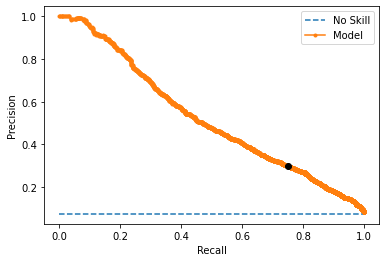

Results of testing data:
          pred_neg  pred_pos
true_neg      4482       791
true_pos       135       276


In [30]:
sampling=None
Bestparam = zip(list(BinaryRural_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(1).columns), 
              BinaryRural_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print('max_depth=', int(BestparamDict['max_depth']), 'eta=', BestparamDict['eta'],'subsample=', BestparamDict['subample'],
     'min_child_weight=', BestparamDict['min_child_weight'],'scale_pos_weight= ',BestparamDict['scale_pos_weight'])

XGBmodel=XGBClassifier(random_state = 42, n_jobs=-1,
                    max_depth=int(BestparamDict['max_depth']), eta=BestparamDict['eta'],subsample=BestparamDict['subample'],
                    min_child_weight=BestparamDict['min_child_weight'],scale_pos_weight=BestparamDict['scale_pos_weight'])
t0 = time.time()
XGBmodel_fitted=XGBmodel.fit(X_train_OHtransformed, y_train)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed, y_train, X_test_OHtransformed, y_test, XGBmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg         3        38
true_pos         2        60
Local Road or Street
          pred_neg  pred_pos
true_neg      4100       279
true_pos       105        60
Major Arterial
          pred_neg  pred_pos
true_neg         2        38
true_pos         1        25
Major Collector
          pred_neg  pred_pos
true_neg       252       317
true_pos        14        88
Minor Arterial
          pred_neg  pred_pos
true_neg        31        91
true_pos         3        38
Minor Collector
          pred_neg  pred_pos
true_neg        94        28
true_pos        10         5
Overall
          pred_neg  pred_pos
true_neg      4482       791
true_pos       135       276
F2score: 0.51 Precision: 0.26 Recall: 0.67 Fpr: 0.15


f2score precision recall   fpr
Interstate              0.87      0.61   0.97  0.93
Local Road or Street     0.3      0.18   0.36  0.06
Major Arterial          0.75       0.4   0.96  0.95
Major Collector         0.54      0.22   0.86  0.56
Minor Arterial          0.65      0.29   0.93  0.75
Minor Collector         0.27      0.15   0.33  0.23
Overall                 0.51      0.26   0.67  0.15

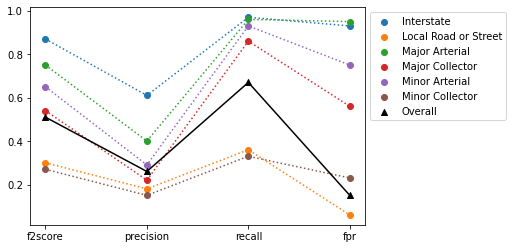

In [31]:
best_thres = model_results[1]
y_test_pred = XGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
cfm_fc_df = cfm_fc(X_test, y_test, y_test_pred_adj)
cfm_fc_df

## Conclusion

The highest f2 score obtained by each algorithm are listed in the following table. It can be observed that eXtreme Gradient Boosting (XGBoost) outperforms the other algorithms in terms of F2 score. Thus, the model fine tuning process, shown in the following sections, would be based on the XGBoost algorithm. 

| Algorithm | F2 | Precision | Recell | AUC | Time* (seconds)|
| :-----------| :----------- |:----------- |:----------- |:----------- |:----------- |
| Logistic Regression | 0.49 | 0.25| 0.65 | 0.436 | Approx. 2.5 |
| Support Vector Machine | 0.49 | 0.26 | 0.63 |0.436 | Approx. 212 |
| Random Forest | 0.49 | 0.22 | 0.7| 0.383 | Approx. 0.25 |
| eXtreme Gradient Boosting | 0.51 | 0.26 | 0.67 | 0.525 | Approx. 3.0 |

*Time needed for training a model 

# Discovering the Best Model with the Selected Algorithm
<a id='discovering-the-best-model-with-selected-algorithm'></a>
[[back to top](#sections)]

Before the fine tuning process, which aims to discover the best model (the selected alogorithm with the corresponding hyperparameters), staff took a closer look at the results generated by the best XGBoost model found in the above section. 

**Findings**

It can be observed from the confusion matrix of the entire dataset and of each roadway functional class that:
- There are only about 1/3 positive cases were classified as the negative cases by the model. For
Interstate, Major Arterial, and Minor Arterial, the false negative rates are very low. For Local Road or Street, Major Collectors, and Minor Collectors, the ratios are relativley high. 
- There are about 15% of negative cases were classified to be positive cases by the model (false positive rate = 15%). Except for Local Road or Street and Minor Collectors, the other roadway classes have more false positives than true negatives. 
Although the ratio is not extremely high, the count number of false positive cases, is large. This means that in the prediction results, there are many roads that are false alarmed.

**Analysis**

- For this project, the ability to be able to capture risky roads is more essential than the ability to identify which roads are safe. Thus, the f2score is selected as the evaluation criteria, and the model is guided to capture as many risky roads as possible. 
- While the f2score evaluate true positive counts, false positive counts, and false negative counts, the number of true negative cases is not evaluated. The true negative counts would not be evaluated if the f2score is the only one criteria used for the model selection.
- The true negative counts is an essential element for calculating the false positive rate. Omitting the true negative counts in the evaluation process might lead to the problem of having a high false positive rate. 

**Decision**

Thus, while the model tuning process is based on the f2score, the final model would be selected basing on both f2score and false positive rate. To be more specific, first, the top 5 models that have the highest f2score would be selected as candidates. Then, the model with the lowest false positive rate among the top 5 candidates would be selected as the final model. 

## Model with highest f2score and lowest false positive rate

The following plots reveal the tradeoff between f2score and false positive rate, under different max_depth values.

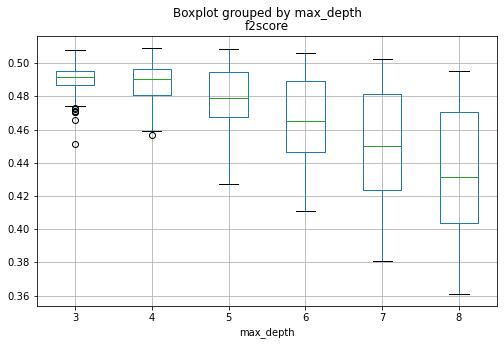

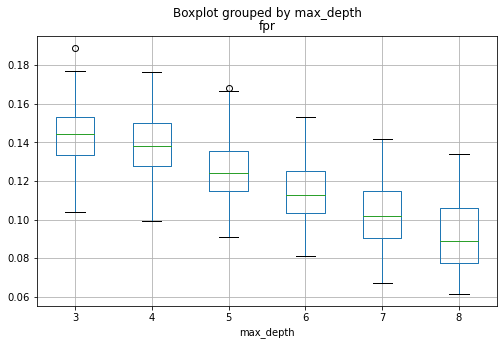

In [32]:
BinaryRural_XGB_search_results.boxplot(column=['f2score'],by='max_depth',figsize=(8,5))
BinaryRural_XGB_search_results.boxplot(column=['fpr'],by='max_depth',figsize=(8,5))

The following two tables reveal the difference in the model selection process before and after including the false positive rate.

In [33]:
Bestmodels = BinaryRural_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(5)
Bestmodels

max_depth  eta  subample  min_child_weight  scale_pos_weight  threshold  \
292          4  0.1       1.0                 4                 5       0.34   
488          5  0.1       0.8                 3                 7       0.41   
472          5  0.1       0.6                 5                 5       0.38   
297          4  0.1       1.0                 5                 5       0.38   
496          5  0.1       0.8                 5                 3       0.26   

     precision    recall   f1score   f2score       fpr    tn   fp   fn   tp  \
292   0.258669  0.671533  0.373478  0.509037  0.150009  4482  791  135  276   
488   0.253636  0.678832  0.369292  0.508382  0.155699  4452  821  132  279   
472   0.277020  0.642336  0.387097  0.508279  0.130666  4584  689  147  264   
297   0.282162  0.635036  0.390719  0.507980  0.125925  4609  664  150  261   
496   0.271066  0.649635  0.382521  0.507798  0.136165  4555  718  144  267   

         time  
292  0.573293  
488  0.784312  
472  0.838070  
297  0.579429  
496  0.786016

In [34]:
Lowfprmodels = Bestmodels.sort_values(by=['fpr']).head(5)
Lowfprmodels

max_depth  eta  subample  min_child_weight  scale_pos_weight  threshold  \
297          4  0.1       1.0                 5                 5       0.38   
472          5  0.1       0.6                 5                 5       0.38   
496          5  0.1       0.8                 5                 3       0.26   
292          4  0.1       1.0                 4                 5       0.34   
488          5  0.1       0.8                 3                 7       0.41   

     precision    recall   f1score   f2score       fpr    tn   fp   fn   tp  \
297   0.282162  0.635036  0.390719  0.507980  0.125925  4609  664  150  261   
472   0.277020  0.642336  0.387097  0.508279  0.130666  4584  689  147  264   
496   0.271066  0.649635  0.382521  0.507798  0.136165  4555  718  144  267   
292   0.258669  0.671533  0.373478  0.509037  0.150009  4482  791  135  276   
488   0.253636  0.678832  0.369292  0.508382  0.155699  4452  821  132  279   

         time  
297  0.579429  
472  0.838070  
496  0.786016  
292  0.573293  
488  0.784312

max_depth= 4 eta= 0.1 subsample= 1.0 min_child_weight= 5.0 scale_pos_weight= 5.0
Time needed for training the model:  2.19 seconds
No Skill Model PR AUC: 0.109
Model PR AUC: 0.526
From Training data:
Best Threshold=0.377818, precision=0.327, recall=0.713, F2_Score=0.576


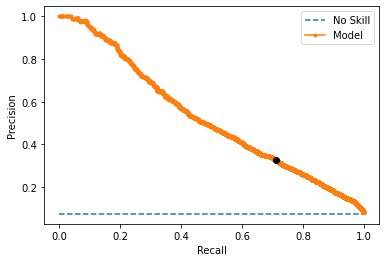

Results of testing data:
          pred_neg  pred_pos
true_neg      4598       675
true_pos       149       262


In [35]:
# model with high f2score and low false positive rate
from xgboost import XGBClassifier
Bestparam = zip(list(Lowfprmodels.head(1).columns), 
              Lowfprmodels.head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print('max_depth=', int(BestparamDict['max_depth']), 'eta=', BestparamDict['eta'],'subsample=', BestparamDict['subample'],
     'min_child_weight=', BestparamDict['min_child_weight'],'scale_pos_weight=',BestparamDict['scale_pos_weight'])

sampling=None
XGBmodel=XGBClassifier(random_state = 42, n_jobs=-1,
                    max_depth=int(BestparamDict['max_depth']), eta=BestparamDict['eta'],subsample=BestparamDict['subample'],
                    min_child_weight=BestparamDict['min_child_weight'],scale_pos_weight=BestparamDict['scale_pos_weight'])
t0 = time.time()
XGBmodel_fitted=XGBmodel.fit(X_train_OHtransformed, y_train)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed, y_train, X_test_OHtransformed, y_test, XGBmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg         4        37
true_pos         2        60
Local Road or Street
          pred_neg  pred_pos
true_neg      4171       208
true_pos       112        53
Major Arterial
          pred_neg  pred_pos
true_neg         2        38
true_pos         1        25
Major Collector
          pred_neg  pred_pos
true_neg       281       288
true_pos        19        83
Minor Arterial
          pred_neg  pred_pos
true_neg        36        86
true_pos         4        37
Minor Collector
          pred_neg  pred_pos
true_neg       104        18
true_pos        11         4
Overall
          pred_neg  pred_pos
true_neg      4598       675
true_pos       149       262
F2score: 0.51 Precision: 0.28 Recall: 0.64 Fpr: 0.13


f2score precision recall   fpr
Interstate              0.87      0.62   0.97   0.9
Local Road or Street    0.29       0.2   0.32  0.05
Major Arterial          0.75       0.4   0.96  0.95
Major Collector         0.53      0.22   0.81  0.51
Minor Arterial          0.64       0.3    0.9   0.7
Minor Collector         0.24      0.18   0.27  0.15
Overall                 0.51      0.28   0.64  0.13

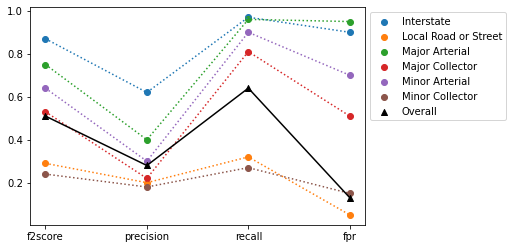

In [36]:
best_thres = model_results[1]
y_test_pred = XGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
# Confusion matrix
Candi2_ModelPerf = cfm_fc(X_test, y_test, y_test_pred_adj)
Candi2_ModelPerf

Compare with the prediction results of testing datasets generated by the previous model:

| Metrics | Model 1 | Model 2| Model2-Model1 Diff. |
| :-----------| :----------- |:----------- |:----------- |
| TP | 276 | 262| -14|
| TN | 4482 | 4598 | +116|
| FP | 791 | 675| -116 |
| FN | 135 | 149 |+14|
| Precision | 0.26 | 0.28 |+0.02|
| Recall (Ture positive rate) | 0.67 | 0.64 |-0.03|
| F2 (5 * precision * recall / 4 * precision + recall)| 0.51 | 0.51 | 0 |
| False positive rate | 0.15 | 0.13 |-0.02|

The table above demonstrates that adding false positive rate into consideration in addition to f2score while selecting the best model (Model 2), a significant reduction in false positive date can be achieved at a relatively much smaller cost of an increased false negative rate. CUUATS staff would like to emphasize that it is virtually impossible to identify the best model that will fulfill every evaluation goal as the nature of the process of identifying the best model itself is a game of balancing competing evaluation goals.

# Resampling
<a id='resampling'></a>
[[back to top](#sections)]

One approach to address the issue of having an imbalanced dataset is to resample the dataset, which includes downsampling the majority class and oversampling the minority class. For this study, the following tasks are conducted to help mitigate the consequences of lacking positive samples and having a large number of negative samples. 

**Step 1:**
Evaluate the oversampling strategies

- Synthetic Minority Oversampling Technique (SMOTE) V.S. Random Oversampling
  
**Step 2:**  
Then, considering the facts that, for different roadway functional classes (i) the imbalance level of positive samples and negative samples are different (ii) the distribution of positive samples and negative samples are different (iii) model shows different performance. Different sampling strategies are applied on different roadway functional classes.

- Evaluate the effect of sampling by roadway functional class
    - Evaluate the effect of oversampling
        - The effect of oversampling positive samples of Interstate
        - The effect of oversampling positive samples of Major Arterial
        - The effect of oversampling positive samples of Minor Arterial
    - Evaluate the effect of downsampling
        - The effect of downsampling negative samples of Major Collector
        - The effect of downsampling negative samples of Minor Collector
        - The effect of downsampling negative samples of Local Road or Street
    
**Step 3:** Examine the results of resampling
    
- Oversampling(Interstate,Major Arterial,Minor Arterial) + Downsampling(Major Collector,Minor Collector,Local Road or Street)

## Evaluating Oversampling strategies
<a id='evaluating-oversampling-strategies'></a>
[[back to top](#sections)]

There are many oversampling methods and the most two popular ones are Random Oversampling and Synthetic Minority Oversampling Technique (SMOTE). Random oversampling makes copies of the minority class. SMOTE sampling choses a random sample and some of its neighbors from the minority class first, then create a synthetic data point along the vector between the selected data point and one of the k neighbors.

### SMOTE

Oversample the minority class (positive samples) to have $SMOTEratio$ percent the number of examples of the majority class (negative samples)

In [37]:
# SMOTE resampling with XGB model enabled by AWS_EC2_BinaryRural_XGB_SMOTE_AllClass
with open(base_file_dir+'data/AWS Tuning results/BinaryRural_XGB_search_results_SMOTE_AllRdClasses.pkl', 'rb') as f:
    BinaryRural_XGB_search_results_SMOTE_AllClass = pickle.load(f)

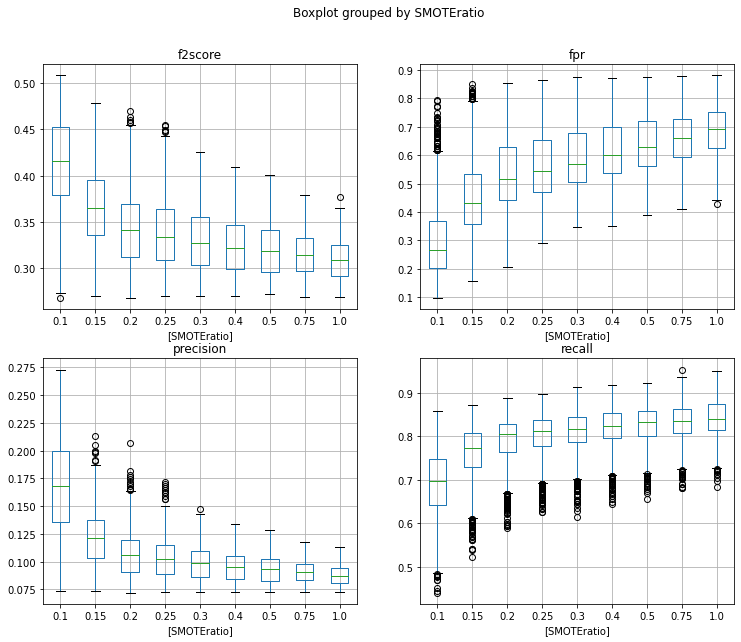

In [38]:
fig,axis = plt.subplots(2,2,figsize=(12,10))
BinaryRural_XGB_search_results_SMOTE_AllClass.boxplot(column=['f2score'], by=['SMOTEratio'],ax=axis[0,0])
BinaryRural_XGB_search_results_SMOTE_AllClass.boxplot(column=['fpr'], by=['SMOTEratio'],ax=axis[0,1])
BinaryRural_XGB_search_results_SMOTE_AllClass.boxplot(column=['precision'], by=['SMOTEratio'],ax=axis[1,0])
BinaryRural_XGB_search_results_SMOTE_AllClass.boxplot(column=['recall'], by=['SMOTEratio'],ax=axis[1,1])

In [39]:
Bestmodels = BinaryRural_XGB_search_results_SMOTE_AllClass.sort_values(by=['f2score'],ascending=False).head(5)
Lowfprmodels = Bestmodels.sort_values(by=['fpr'])
Lowfprmodels

SMOTEratio  max_depth  eta  subample  min_child_weight  \
1145         0.1          8  0.1       0.6                 5   
685          0.1          6  0.1       0.6                 3   
235          0.1          4  0.1       0.6                 3   
465          0.1          5  0.1       0.6                 4   
522          0.1          5  0.1       1.0                 5   

      scale_pos_weight  threshold  precision    recall   f1score   f2score  \
1145                 1       0.14   0.268916  0.639903  0.378690  0.501526   
685                  1       0.13   0.263889  0.647202  0.374912  0.501508   
235                  1       0.13   0.257547  0.664234  0.371176  0.504808   
465                  1       0.12   0.255280  0.676399  0.370667  0.508599   
522                  5       0.36   0.232595  0.715328  0.351045  0.505502   

           fpr    tn   fp   fn   tp      time  
1145  0.135596  4558  715  148  263  1.573497  
685   0.140717  4531  742  145  266  1.168462  
235   0.149251  4486  787  138  273  1.095194  
465   0.153802  4462  811  133  278  1.275826  
522   0.183956  4303  970  117  294  0.979306

SMOTEratio= 0.1 max_depth= 8 eta= 0.1 subsample= 0.6 min_child_weight= 5.0 scale_pos_weight= 1.0
Time needed for training the model:  4.08 seconds
No Skill Model PR AUC: 0.110
Model PR AUC: 0.729
From Training data:
Best Threshold=0.149222, precision=0.482, recall=0.822, F2_Score=0.720


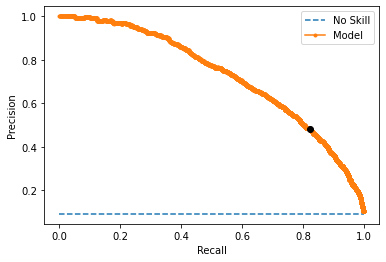

Results of testing data:
          pred_neg  pred_pos
true_neg      4615       658
true_pos       167       244


In [40]:
Bestparam = zip(list(Lowfprmodels.head(1).columns), 
              Lowfprmodels.head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print('SMOTEratio=',BestparamDict['SMOTEratio'],'max_depth=', int(BestparamDict['max_depth']), 'eta=', BestparamDict['eta'],'subsample=', BestparamDict['subample'],
     'min_child_weight=', BestparamDict['min_child_weight'],'scale_pos_weight=',BestparamDict['scale_pos_weight'])

sampling = SMOTE(sampling_strategy=BestparamDict['SMOTEratio'],random_state = 42)

from xgboost import XGBClassifier

XGBmodel=XGBClassifier(random_state = 42, n_jobs=-1,
                    max_depth=int(BestparamDict['max_depth']), eta=BestparamDict['eta'],subsample=BestparamDict['subample'],
                    min_child_weight=BestparamDict['min_child_weight'],scale_pos_weight=BestparamDict['scale_pos_weight'])

X_train_OHtransformed_Oversampled, y_train_Oversampled = sampling.fit_resample(X_train_OHtransformed, y_train)

t0 = time.time()
SMOTE_XGBmodel_fitted=XGBmodel.fit(X_train_OHtransformed_Oversampled, y_train_Oversampled)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed_Oversampled, y_train_Oversampled, X_test_OHtransformed, y_test, SMOTE_XGBmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg        14        27
true_pos         2        60
Local Road or Street
          pred_neg  pred_pos
true_neg      4093       286
true_pos       115        50
Major Arterial
          pred_neg  pred_pos
true_neg         9        31
true_pos         2        24
Major Collector
          pred_neg  pred_pos
true_neg       340       229
true_pos        32        70
Minor Arterial
          pred_neg  pred_pos
true_neg        53        69
true_pos         6        35
Minor Collector
          pred_neg  pred_pos
true_neg       106        16
true_pos        10         5
Overall
          pred_neg  pred_pos
true_neg      4615       658
true_pos       167       244
F2score: 0.48 Precision: 0.27 Recall: 0.59 Fpr: 0.12


f2score precision recall   fpr
Interstate               0.9      0.69   0.97  0.66
Local Road or Street    0.25      0.15    0.3  0.07
Major Arterial          0.75      0.44   0.92  0.78
Major Collector          0.5      0.23   0.69   0.4
Minor Arterial          0.65      0.34   0.85  0.57
Minor Collector         0.31      0.24   0.33  0.13
Overall                 0.48      0.27   0.59  0.12

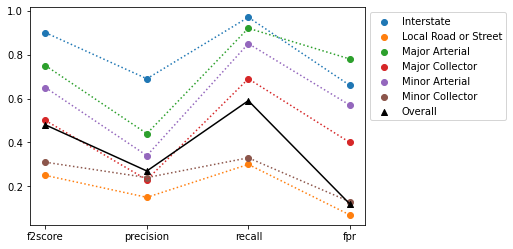

In [41]:
best_thres = model_results[1]
y_test_pred = SMOTE_XGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
# Confusion matrix by each road functional class
SMOTE_AllRdClass_ModelPerf = cfm_fc(X_test, y_test, y_test_pred_adj)
SMOTE_AllRdClass_ModelPerf

### Random Oversample

Copy $Sampleratio$ percent of positive samples and add to the training data.

In [42]:
# Random oversampling with XGB model enabled by AWS_EC2_BinaryRural_XGB_Dup_AllClass.py
with open(base_file_dir+'data/AWS Tuning results/BinaryRural_XGB_search_results_Dup_AllRdClasses_rename.pkl', 'rb') as f:
    BinaryRural_XGB_search_results_Dup_AllRdClasses = pickle.load(f)

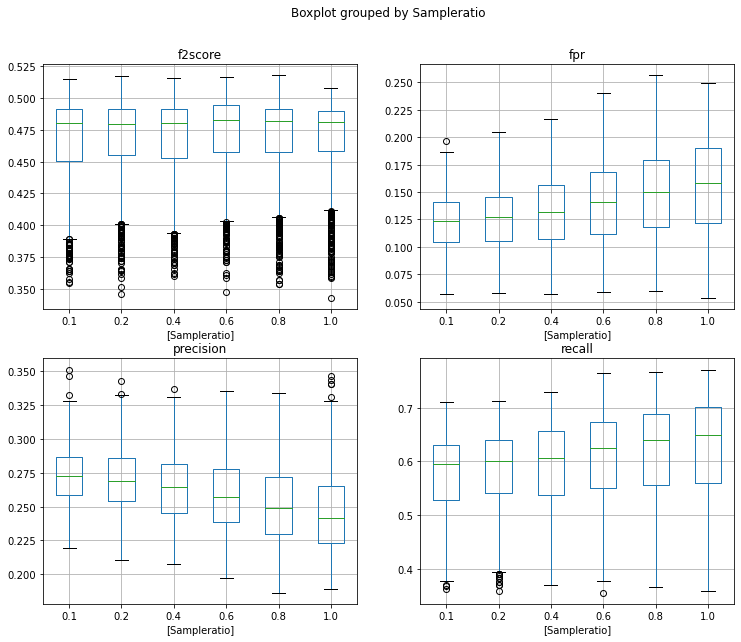

In [43]:
fig,axis = plt.subplots(2,2,figsize=(12,10))
BinaryRural_XGB_search_results_Dup_AllRdClasses.boxplot(column=['f2score'], by=['Sampleratio'],ax=axis[0,0])
BinaryRural_XGB_search_results_Dup_AllRdClasses.boxplot(column=['fpr'], by=['Sampleratio'],ax=axis[0,1])
BinaryRural_XGB_search_results_Dup_AllRdClasses.boxplot(column=['precision'], by=['Sampleratio'],ax=axis[1,0])
BinaryRural_XGB_search_results_Dup_AllRdClasses.boxplot(column=['recall'], by=['Sampleratio'],ax=axis[1,1])

In [44]:
Bestmodels = BinaryRural_XGB_search_results_Dup_AllRdClasses.sort_values(by=['f2score'],ascending=False).head(5)
Lowfprmodels = Bestmodels.sort_values(by=['fpr'])
Lowfprmodels

Sampleratio  max_depth  eta  subample  min_child_weight  \
1721          0.2          4  0.3       1.0                 5   
128           0.1          3  0.3       1.0                 1   
4750          0.6          6  0.1       0.8                 1   
5710          0.8          4  0.3       0.6                 3   
2792          0.4          3  0.3       0.6                 4   

      scale_pos_weight  threshold  precision    recall   f1score   f2score  \
1721                 3       0.30   0.281971  0.654501  0.394139  0.517706   
128                  7       0.45   0.270217  0.666667  0.384561  0.515425   
4750                 1       0.15   0.268222  0.671533  0.383333  0.516274   
5710                 1       0.15   0.255111  0.698297  0.373698  0.518238   
2792                 5       0.40   0.242798  0.717762  0.362854  0.515915   

           fpr    tn   fp   fn   tp      time  
1721  0.129907  4588  685  142  269  0.748170  
128   0.140338  4533  740  137  274  0.595598  
4750  0.142803  4520  753  135  276  1.481167  
5710  0.158923  4435  838  124  287  0.883319  
2792  0.174474  4353  920  116  295  0.842112

Sampleratio= 0.2 max_depth= 4 eta= 0.3 subsample= 1.0 min_child_weight= 5.0 scale_pos_weight= 3.0
Time needed for training the model:  2.21 seconds
No Skill Model PR AUC: 0.109
Model PR AUC: 0.643
From Training data:
Best Threshold=0.297090, precision=0.404, recall=0.811, F2_Score=0.675


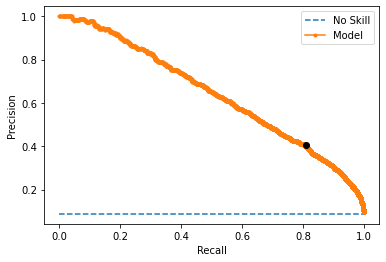

Results of testing data:
          pred_neg  pred_pos
true_neg      4581       692
true_pos       141       270


In [45]:
Bestparam = zip(list(Lowfprmodels.head(1).columns), 
              Lowfprmodels.head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print('Sampleratio=',BestparamDict['Sampleratio'],'max_depth=', int(BestparamDict['max_depth']), 'eta=', BestparamDict['eta'],'subsample=', BestparamDict['subample'],
     'min_child_weight=', BestparamDict['min_child_weight'],'scale_pos_weight=',BestparamDict['scale_pos_weight'])

sampratio = BestparamDict['Sampleratio']
pos_counts = df_rural_train_bi_label.value_counts()[1.0]
neg_counts = df_rural_train_bi_label.value_counts()[0.0]
addpos_counts = int(pos_counts*sampratio)
np.random.seed(42)
index_to_dup = sorted(np.random.choice(X_train[y_train==1].index,
                    size=addpos_counts, replace=False))
id_to_dup = np.where(X_train.index.isin(index_to_dup))[0]
X_train_OHtransformed_Oversampled = np.concatenate((X_train_OHtransformed,X_train_OHtransformed[id_to_dup,:]),axis=0)
y_train_Oversampled = np.concatenate((y_train.values,y_train.values[id_to_dup]),axis=0)

t0 = time.time()
XGBmodel=XGBClassifier(random_state = 42, n_jobs=-1,
                    max_depth=int(BestparamDict['max_depth']), eta=BestparamDict['eta'],subsample=BestparamDict['subample'],
                    min_child_weight=BestparamDict['min_child_weight'],scale_pos_weight=BestparamDict['scale_pos_weight'])
DupXGBmodel_fitted=XGBmodel.fit(X_train_OHtransformed_Oversampled, y_train_Oversampled)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed_Oversampled, y_train_Oversampled, X_test_OHtransformed, y_test, DupXGBmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg        14        27
true_pos         2        60
Local Road or Street
          pred_neg  pred_pos
true_neg      4115       264
true_pos       107        58
Major Arterial
          pred_neg  pred_pos
true_neg         9        31
true_pos         1        25
Major Collector
          pred_neg  pred_pos
true_neg       299       270
true_pos        17        85
Minor Arterial
          pred_neg  pred_pos
true_neg        43        79
true_pos         5        36
Minor Collector
          pred_neg  pred_pos
true_neg       101        21
true_pos         9         6
Overall
          pred_neg  pred_pos
true_neg      4581       692
true_pos       141       270
F2score: 0.52 Precision: 0.28 Recall: 0.66 Fpr: 0.13


f2score precision recall   fpr
Interstate               0.9      0.69   0.97  0.66
Local Road or Street     0.3      0.18   0.35  0.06
Major Arterial          0.78      0.45   0.96  0.78
Major Collector         0.56      0.24   0.83  0.47
Minor Arterial          0.65      0.31   0.88  0.65
Minor Collector         0.34      0.22    0.4  0.17
Overall                 0.52      0.28   0.66  0.13

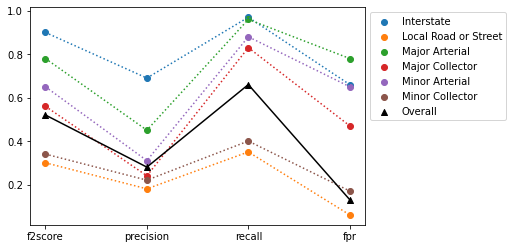

In [46]:
best_thres = model_results[1]
# Check the performance on test data
y_test_pred = DupXGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
# Confusion matrix by each road functional class
Dup_AllRdClass_ModelPerf = cfm_fc(X_test, y_test, y_test_pred_adj)
Dup_AllRdClass_ModelPerf

Analysis:
It can be observed that 

### Comparing the Results of the SMOTE and Random Oversampling

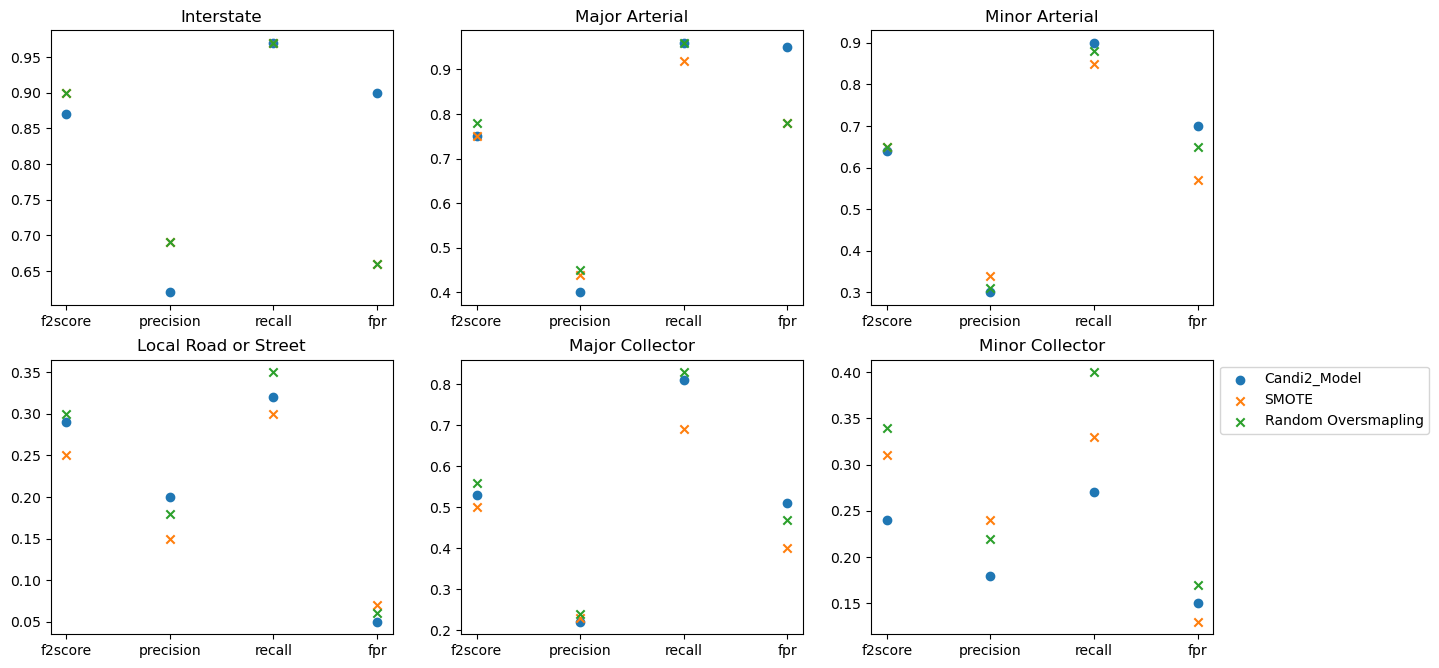

In [47]:
axdict = dict({'Interstate':(0,0),'Major Arterial':(0,1),'Minor Arterial':(0,2),
              'Local Road or Street':(1,0),'Major Collector':(1,1),'Minor Collector':(1,2)})
rdclass = ['Interstate', 'Local Road or Street', 'Major Arterial','Major Collector', 'Minor Arterial', 'Minor Collector']
fig,ax = plt.subplots(2,3,figsize=(15,8),dpi=100)
for i,col in enumerate(rdclass):
    ax[axdict[col]].scatter(x=['f2score','precision','recall','fpr'],y=Candi2_ModelPerf.T[col],label='Candi2_Model')
    ax[axdict[col]].scatter(x=['f2score','precision','recall','fpr'],y=SMOTE_AllRdClass_ModelPerf.T[col],label='SMOTE',marker='x')
    ax[axdict[col]].scatter(x=['f2score','precision','recall','fpr'],y=Dup_AllRdClass_ModelPerf.T[col],label='Random Oversmapling',marker='x')
    ax[axdict[col]].set_title(col)
plt.legend(bbox_to_anchor=(1,1))

<mark>Conclusion: </mark>

Examining the results of the two oversampling methods, it can be concluded that:
- Both methods can help improve the model performance in most cases while having different impacts on different roadway class.
- To achieve the similar performance, SMOTE needs a larger number of oversampled data than the Random Oversampling method.

## Evaluating the Effect of Sampling by Roadway Functional Class
<a id='evaluating-the-effect-of-sampling-by-roadway-functional-class'></a>
[[back to top](#sections)]

### Oversampling

oversampled_data = (1+oversample ratio) * number_of_positive_samples

In [48]:
X_train_Int = df_rural_train_sub[df_rural_train_sub['functional_classification']=='Interstate']
X_train_OHtransformed_Int = X_train_OHtransformed[df_rural_train_sub['functional_classification']=='Interstate',:]
y_train_Int = df_rural_train_bi_label[df_rural_train_sub['functional_classification']=='Interstate']

X_train_LocRd = df_rural_train_sub[df_rural_train_sub['functional_classification']=='Local Road or Street']
X_train_OHtransformed_LocRd = X_train_OHtransformed[df_rural_train_sub['functional_classification']=='Local Road or Street']
y_train_LocRd = df_rural_train_bi_label[df_rural_train_sub['functional_classification']=='Local Road or Street']

X_train_MajArt = df_rural_train_sub[df_rural_train_sub['functional_classification']=='Major Arterial']
X_train_OHtransformed_MajArt = X_train_OHtransformed[df_rural_train_sub['functional_classification']=='Major Arterial']
y_train_MajArt = df_rural_train_bi_label[df_rural_train_sub['functional_classification']=='Major Arterial']

X_train_MajCol = df_rural_train_sub[df_rural_train_sub['functional_classification']=='Major Collector']
X_train_OHtransformed_MajCol = X_train_OHtransformed[df_rural_train_sub['functional_classification']=='Major Collector']
y_train_MajCol = df_rural_train_bi_label[df_rural_train_sub['functional_classification']=='Major Collector']

X_train_MinArt = df_rural_train_sub[df_rural_train_sub['functional_classification']=='Minor Arterial']
X_train_OHtransformed_MinArt = X_train_OHtransformed[df_rural_train_sub['functional_classification']=='Minor Arterial']
y_train_MinArt = df_rural_train_bi_label[df_rural_train_sub['functional_classification']=='Minor Arterial']

X_train_MinCol = df_rural_train_sub[df_rural_train_sub['functional_classification']=='Minor Collector']
X_train_OHtransformed_MinCol = X_train_OHtransformed[df_rural_train_sub['functional_classification']=='Minor Collector']
y_train_MinCol = df_rural_train_bi_label[df_rural_train_sub['functional_classification']=='Minor Collector']


In [49]:
# DupIntPerform = pd.read_csv(base_file_dir+'data/AWS Tuning results/Binary_Rural_DupIntPerform.csv')
# DupMajArtPerform = pd.read_csv(base_file_dir+'data/AWS Tuning results/Binary_Rural_DupMajArtPerform.csv')
# DupMinArtPerform = pd.read_csv(base_file_dir+'data/AWS Tuning results/Binary_Rural_DupMinArtPerform.csv')

Conclusion:
- Oversampling leads to higher precision and lower false positive rate.
- Oversampling leads to lower recall. Most TP losses are from Local Road and Street and Major Collector.  
- Considering the evaluation criteria of high f2score and low false positive rate, the most appropriate range of oversampling ratio is (0,0.2].

In [50]:
dup_pos_ratio = 0.1
X_train_Int_Oversampled,X_train_OHtransformed_Int_Oversampled,y_train_Int_Oversampled = dup_rdclass(dup_pos_ratio,X_train_Int,X_train_OHtransformed_Int,y_train_Int)
X_train_MajArt_Oversampled,X_train_OHtransformed_MajArt_Oversampled,y_train_MajArt_Oversampled = dup_rdclass(dup_pos_ratio,X_train_MajArt,X_train_OHtransformed_MajArt,y_train_MajArt)
X_train_MinArt_Oversampled,X_train_OHtransformed_MinArt_Oversampled,y_train_MinArt_Oversampled = dup_rdclass(dup_pos_ratio,X_train_MinArt,X_train_OHtransformed_MinArt,y_train_MinArt)


In [51]:
X_train_OHtransformed_Resampled = np.concatenate((
    X_train_OHtransformed_Int_Oversampled,X_train_OHtransformed_MajArt_Oversampled,X_train_OHtransformed_MinArt_Oversampled,
    X_train_OHtransformed_LocRd,X_train_OHtransformed_MajCol,X_train_OHtransformed_MinCol
),axis=0)
y_train_Resampled = np.concatenate((
    y_train_Int_Oversampled.values,y_train_MajArt_Oversampled.values, y_train_MinArt_Oversampled.values,
    y_train_LocRd.values,y_train_MajCol.values,y_train_MinCol.values
),axis=0)

max_depth= 4 eta= 0.1 subsample= 1.0 min_child_weight= 5.0 scale_pos_weight= 5.0
Time needed for training the model:  2.33 seconds
No Skill Model PR AUC: 0.131
Model PR AUC: 0.544
From Training data:
Best Threshold=0.374222, precision=0.332, recall=0.723, F2_Score=0.585


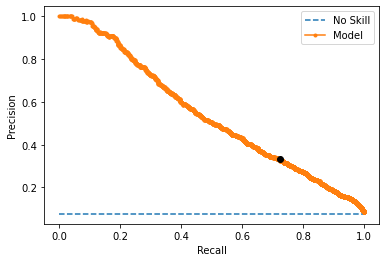

Results of testing data:
          pred_neg  pred_pos
true_neg      4584       689
true_pos       156       255
Interstate
          pred_neg  pred_pos
true_neg         5        36
true_pos         2        60
Local Road or Street
          pred_neg  pred_pos
true_neg      4163       216
true_pos       118        47
Major Arterial
          pred_neg  pred_pos
true_neg         2        38
true_pos         1        25
Major Collector
          pred_neg  pred_pos
true_neg       277       292
true_pos        20        82
Minor Arterial
          pred_neg  pred_pos
true_neg        35        87
true_pos         4        37
Minor Collector
          pred_neg  pred_pos
true_neg       102        20
true_pos        11         4
Overall
          pred_neg  pred_pos
true_neg      4584       689
true_pos       156       255
F2score: 0.49 Precision: 0.27 Recall: 0.62 Fpr: 0.13


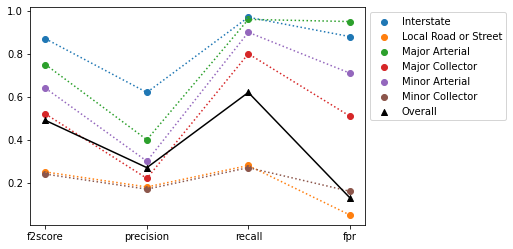

In [52]:
Bestmodels = BinaryRural_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(5)
Lowfprmodels = Bestmodels.sort_values(by=['fpr']).head(5)
# model with high f2score and low false positive rate
from xgboost import XGBClassifier
Bestparam = zip(list(Lowfprmodels.head(1).columns), 
              Lowfprmodels.head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print('max_depth=', int(BestparamDict['max_depth']), 'eta=', BestparamDict['eta'],'subsample=', BestparamDict['subample'],
     'min_child_weight=', BestparamDict['min_child_weight'],'scale_pos_weight=',BestparamDict['scale_pos_weight'])

sampling=None
XGBmodel=XGBClassifier(random_state = 42, n_jobs=-1,
                    max_depth=int(BestparamDict['max_depth']), eta=BestparamDict['eta'],subsample=BestparamDict['subample'],
                    min_child_weight=BestparamDict['min_child_weight'],scale_pos_weight=BestparamDict['scale_pos_weight'])
t0 = time.time()
XGBmodel_fitted=XGBmodel.fit(X_train_OHtransformed_Resampled, y_train_Resampled)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed_Resampled, y_train_Resampled, 
                                      X_test_OHtransformed, y_test, XGBmodel_fitted)

best_thres = model_results[1]
y_test_pred = XGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
cfm_fc_df = cfm_fc(X_test, y_test, y_test_pred_adj)

### Downsampling

In [53]:
# with open(base_file_dir+'data/AWS Tuning results/BinaryRural_XGB_search_results_drop.pkl', 'rb') as f:
#     BinaryRural_XGB_search_results_drop = pickle.load(f)

Conclusion:
- Downsampling can help decrease false positive rate with the side effect of decreasing the recall.  
- Considering the evaluation criteria of high f2score and low false positive rate, the most appropriate range of oversampling ratio is (0,0.25].

In [54]:
drop_neg_ratio = 0.5
X_train_LocRd_drop,X_train_OHtransformed_LocRd_drop, y_train_LocRd_drop = drop_rdclass(drop_neg_ratio,X_train_LocRd,X_train_OHtransformed_LocRd,y_train_LocRd)
X_train_MajCol_drop,X_train_OHtransformed_MajCol_drop, y_train_MajCol_drop = drop_rdclass(drop_neg_ratio,X_train_MajCol,X_train_OHtransformed_MajCol,y_train_MajCol)
X_train_MinCol_drop,X_train_OHtransformed_MinCol_drop, y_train_MinCol_drop = drop_rdclass(drop_neg_ratio,X_train_MinCol,X_train_OHtransformed_MinCol,y_train_MinCol)

In [55]:
X_train_OHtransformed_Resampled = np.concatenate((
    X_train_OHtransformed_Int,X_train_OHtransformed_MajArt,X_train_OHtransformed_MinArt,
    X_train_OHtransformed_LocRd_drop,X_train_OHtransformed_MajCol_drop,X_train_OHtransformed_MinCol_drop
),axis=0)
y_train_Resampled = np.concatenate((
    y_train_Int.values,y_train_MajArt.values, y_train_MinArt.values,
    y_train_LocRd_drop.values,y_train_MajCol_drop.values,y_train_MinCol_drop.values
),axis=0)

max_depth= 4 eta= 0.1 subsample= 1.0 min_child_weight= 5.0 scale_pos_weight= 5.0
Time needed for training the model:  1.3 seconds
No Skill Model PR AUC: 0.115
Model PR AUC: 0.612
From Training data:
Best Threshold=0.445866, precision=0.391, recall=0.798, F2_Score=0.661


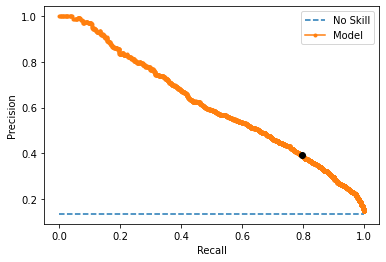

Results of testing data:
          pred_neg  pred_pos
true_neg      4263      1010
true_pos       121       290
Interstate
          pred_neg  pred_pos
true_neg        11        30
true_pos         2        60
Local Road or Street
          pred_neg  pred_pos
true_neg      3900       479
true_pos        94        71
Major Arterial
          pred_neg  pred_pos
true_neg         4        36
true_pos         1        25
Major Collector
          pred_neg  pred_pos
true_neg       220       349
true_pos        13        89
Minor Arterial
          pred_neg  pred_pos
true_neg        44        78
true_pos         4        37
Minor Collector
          pred_neg  pred_pos
true_neg        84        38
true_pos         7         8
Overall
          pred_neg  pred_pos
true_neg      4263      1010
true_pos       121       290
F2score: 0.49 Precision: 0.22 Recall: 0.71 Fpr: 0.19


f2score precision recall   fpr
Interstate              0.89      0.67   0.97  0.73
Local Road or Street    0.29      0.13   0.43  0.11
Major Arterial          0.76      0.41   0.96   0.9
Major Collector         0.53       0.2   0.87  0.61
Minor Arterial          0.66      0.32    0.9  0.64
Minor Collector         0.38      0.17   0.53  0.31
Overall                 0.49      0.22   0.71  0.19

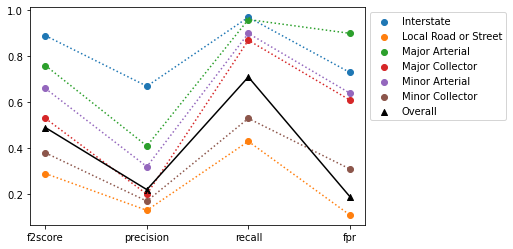

In [56]:
Bestmodels = BinaryRural_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(5)
Lowfprmodels = Bestmodels.sort_values(by=['fpr']).head(5)
# model with high f2score and low false positive rate
from xgboost import XGBClassifier
Bestparam = zip(list(Lowfprmodels.head(1).columns), 
              Lowfprmodels.head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print('max_depth=', int(BestparamDict['max_depth']), 'eta=', BestparamDict['eta'],'subsample=', BestparamDict['subample'],
     'min_child_weight=', BestparamDict['min_child_weight'],'scale_pos_weight=',BestparamDict['scale_pos_weight'])

sampling=None
XGBmodel=XGBClassifier(random_state = 42, n_jobs=-1,
                    max_depth=int(BestparamDict['max_depth']), eta=BestparamDict['eta'],subsample=BestparamDict['subample'],
                    min_child_weight=BestparamDict['min_child_weight'],scale_pos_weight=BestparamDict['scale_pos_weight'])
t0 = time.time()
XGBmodel_fitted=XGBmodel.fit(X_train_OHtransformed_Resampled, y_train_Resampled)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed_Resampled, y_train_Resampled, 
                                      X_test_OHtransformed, y_test, XGBmodel_fitted)

best_thres = model_results[1]
y_test_pred = XGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
cfm_fc_df = cfm_fc(X_test, y_test, y_test_pred_adj)
cfm_fc_df

### Oversampling + Downsampling

In [57]:
X_train_Int = df_rural_train_sub[df_rural_train_sub['functional_classification']=='Interstate']
X_train_OHtransformed_Int = X_train_OHtransformed[df_rural_train_sub['functional_classification']=='Interstate',:]
y_train_Int = df_rural_train_bi_label[df_rural_train_sub['functional_classification']=='Interstate']

X_train_LocRd = df_rural_train_sub[df_rural_train_sub['functional_classification']=='Local Road or Street']
X_train_OHtransformed_LocRd = X_train_OHtransformed[df_rural_train_sub['functional_classification']=='Local Road or Street']
y_train_LocRd = df_rural_train_bi_label[df_rural_train_sub['functional_classification']=='Local Road or Street']

X_train_MajArt = df_rural_train_sub[df_rural_train_sub['functional_classification']=='Major Arterial']
X_train_OHtransformed_MajArt = X_train_OHtransformed[df_rural_train_sub['functional_classification']=='Major Arterial']
y_train_MajArt = df_rural_train_bi_label[df_rural_train_sub['functional_classification']=='Major Arterial']

X_train_MajCol = df_rural_train_sub[df_rural_train_sub['functional_classification']=='Major Collector']
X_train_OHtransformed_MajCol = X_train_OHtransformed[df_rural_train_sub['functional_classification']=='Major Collector']
y_train_MajCol = df_rural_train_bi_label[df_rural_train_sub['functional_classification']=='Major Collector']

X_train_MinArt = df_rural_train_sub[df_rural_train_sub['functional_classification']=='Minor Arterial']
X_train_OHtransformed_MinArt = X_train_OHtransformed[df_rural_train_sub['functional_classification']=='Minor Arterial']
y_train_MinArt = df_rural_train_bi_label[df_rural_train_sub['functional_classification']=='Minor Arterial']

X_train_MinCol = df_rural_train_sub[df_rural_train_sub['functional_classification']=='Minor Collector']
X_train_OHtransformed_MinCol = X_train_OHtransformed[df_rural_train_sub['functional_classification']=='Minor Collector']
y_train_MinCol = df_rural_train_bi_label[df_rural_train_sub['functional_classification']=='Minor Collector']

In [58]:
drop_neg_ratio = 0.25
X_train_LocRd_drop,X_train_OHtransformed_LocRd_drop, y_train_LocRd_drop = drop_rdclass(drop_neg_ratio,X_train_LocRd,X_train_OHtransformed_LocRd,y_train_LocRd)
X_train_MajCol_drop,X_train_OHtransformed_MajCol_drop, y_train_MajCol_drop = drop_rdclass(drop_neg_ratio,X_train_MajCol,X_train_OHtransformed_MajCol,y_train_MajCol)
X_train_MinCol_drop,X_train_OHtransformed_MinCol_drop, y_train_MinCol_drop = drop_rdclass(drop_neg_ratio,X_train_MinCol,X_train_OHtransformed_MinCol,y_train_MinCol)

In [59]:
dup_pos_ratio = 0.1
X_train_Int_Oversampled,X_train_OHtransformed_Int_Oversampled,y_train_Int_Oversampled = dup_rdclass(dup_pos_ratio,X_train_Int,X_train_OHtransformed_Int,y_train_Int)
X_train_MajArt_Oversampled,X_train_OHtransformed_MajArt_Oversampled,y_train_MajArt_Oversampled = dup_rdclass(dup_pos_ratio,X_train_MajArt,X_train_OHtransformed_MajArt,y_train_MajArt)
X_train_MinArt_Oversampled,X_train_OHtransformed_MinArt_Oversampled,y_train_MinArt_Oversampled = dup_rdclass(dup_pos_ratio,X_train_MinArt,X_train_OHtransformed_MinArt,y_train_MinArt)


In [60]:
X_train_OHtransformed_Resampled = np.concatenate((
    X_train_OHtransformed_Int_Oversampled,X_train_OHtransformed_MajArt_Oversampled,X_train_OHtransformed_MinArt_Oversampled,
    X_train_OHtransformed_LocRd_drop,X_train_OHtransformed_MajCol_drop,X_train_OHtransformed_MinCol_drop
),axis=0)
y_train_Resampled = np.concatenate((
    y_train_Int_Oversampled.values,y_train_MajArt_Oversampled.values, y_train_MinArt_Oversampled.values,
    y_train_LocRd_drop.values,y_train_MajCol_drop.values,y_train_MinCol_drop.values
),axis=0)

max_depth= 4 eta= 0.1 subsample= 1.0 min_child_weight= 5.0 scale_pos_weight= 5.0
Time needed for training the model:  1.86 seconds
No Skill Model PR AUC: 0.121
Model PR AUC: 0.581
From Training data:
Best Threshold=0.387590, precision=0.351, recall=0.772, F2_Score=0.622


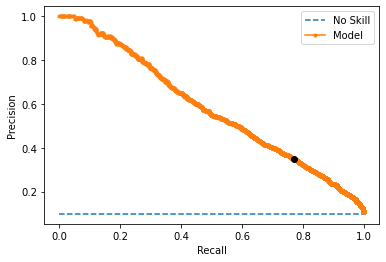

Results of testing data:
          pred_neg  pred_pos
true_neg      4422       851
true_pos       132       279
Interstate
          pred_neg  pred_pos
true_neg         6        35
true_pos         2        60
Local Road or Street
          pred_neg  pred_pos
true_neg      4032       347
true_pos       102        63
Major Arterial
          pred_neg  pred_pos
true_neg         4        36
true_pos         1        25
Major Collector
          pred_neg  pred_pos
true_neg       247       322
true_pos        14        88
Minor Arterial
          pred_neg  pred_pos
true_neg        38        84
true_pos         3        38
Minor Collector
          pred_neg  pred_pos
true_neg        95        27
true_pos        10         5
Overall
          pred_neg  pred_pos
true_neg      4422       851
true_pos       132       279
F2score: 0.5 Precision: 0.25 Recall: 0.68 Fpr: 0.16


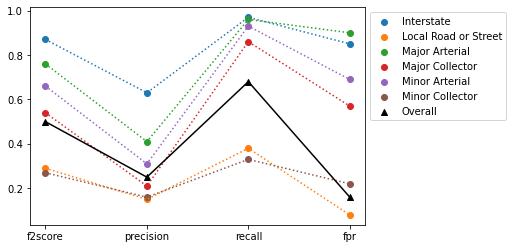

In [61]:
Bestmodels = BinaryRural_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(5)
Lowfprmodels = Bestmodels.sort_values(by=['fpr']).head(5)
# model with high f2score and low false positive rate
from xgboost import XGBClassifier
Bestparam = zip(list(Lowfprmodels.head(1).columns), 
              Lowfprmodels.head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print('max_depth=', int(BestparamDict['max_depth']), 'eta=', BestparamDict['eta'],'subsample=', BestparamDict['subample'],
     'min_child_weight=', BestparamDict['min_child_weight'],'scale_pos_weight=',BestparamDict['scale_pos_weight'])

sampling=None
XGBmodel=XGBClassifier(random_state = 42, n_jobs=-1,
                    max_depth=int(BestparamDict['max_depth']), eta=BestparamDict['eta'],subsample=BestparamDict['subample'],
                    min_child_weight=BestparamDict['min_child_weight'],scale_pos_weight=BestparamDict['scale_pos_weight'])
t0 = time.time()
XGBmodel_fitted=XGBmodel.fit(X_train_OHtransformed_Resampled, y_train_Resampled)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed_Resampled, y_train_Resampled, 
                                      X_test_OHtransformed, y_test, XGBmodel_fitted)

best_thres = model_results[1]
y_test_pred = XGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
cfm_fc_df = cfm_fc(X_test, y_test, y_test_pred_adj)

### Conclusion

Resampling would not be applied for this study for the following reasons:
- Invalidity: The result shows that resampling is of no use for performance improvement.
- Uncertainty: Resampling adds uncertainty to the model performance, the performance heavily relies on which data points are resampled. 
- Complexity: Resampling data adds complexity to the model training process. The resampling ratio should be redefined once the distribution of the training data is changed.

## Final Model
<a id='final-model'></a>
[[back to top](#sections)]

<mark> XGB model with highest f2score and lowest false positive rate is selcted as the final model. </mark>

max_depth= 4 eta= 0.1 subsample= 1.0 min_child_weight= 5.0 scale_pos_weight= 5.0
Time needed for training the model:  2.34 seconds
No Skill Model PR AUC: 0.097
Model PR AUC: 0.526
From Training data:
Best Threshold=0.377818, precision=0.327, recall=0.713, F2_Score=0.576


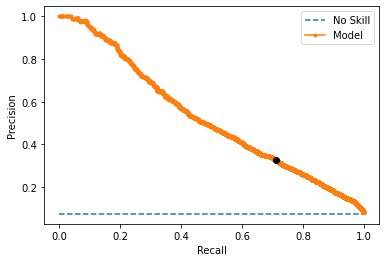

Results of testing data:
          pred_neg  pred_pos
true_neg      4598       675
true_pos       149       262
Interstate
          pred_neg  pred_pos
true_neg         4        37
true_pos         2        60
Local Road or Street
          pred_neg  pred_pos
true_neg      4171       208
true_pos       112        53
Major Arterial
          pred_neg  pred_pos
true_neg         2        38
true_pos         1        25
Major Collector
          pred_neg  pred_pos
true_neg       281       288
true_pos        19        83
Minor Arterial
          pred_neg  pred_pos
true_neg        36        86
true_pos         4        37
Minor Collector
          pred_neg  pred_pos
true_neg       104        18
true_pos        11         4
Overall
          pred_neg  pred_pos
true_neg      4598       675
true_pos       149       262
F2score: 0.51 Precision: 0.28 Recall: 0.64 Fpr: 0.13


f2score precision recall   fpr
Interstate              0.87      0.62   0.97   0.9
Local Road or Street    0.29       0.2   0.32  0.05
Major Arterial          0.75       0.4   0.96  0.95
Major Collector         0.53      0.22   0.81  0.51
Minor Arterial          0.64       0.3    0.9   0.7
Minor Collector         0.24      0.18   0.27  0.15
Overall                 0.51      0.28   0.64  0.13

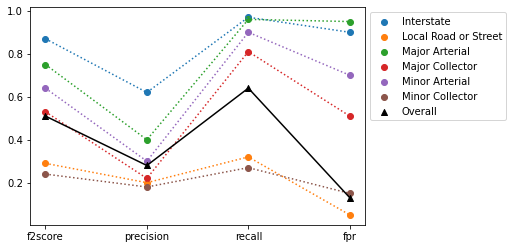

In [62]:
Bestmodels = BinaryRural_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(5)
Lowfprmodels = Bestmodels.sort_values(by=['fpr']).head(5)

# model with high f2score and low false positive rate
from xgboost import XGBClassifier
Bestparam = zip(list(Lowfprmodels.head(1).columns), 
              Lowfprmodels.head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print('max_depth=', int(BestparamDict['max_depth']), 'eta=', BestparamDict['eta'],'subsample=', BestparamDict['subample'],
     'min_child_weight=', BestparamDict['min_child_weight'],'scale_pos_weight=',BestparamDict['scale_pos_weight'])

sampling=None
XGBmodel=XGBClassifier(random_state = 42, n_jobs=-1,
                    max_depth=int(BestparamDict['max_depth']), eta=BestparamDict['eta'],subsample=BestparamDict['subample'],
                    min_child_weight=BestparamDict['min_child_weight'],scale_pos_weight=BestparamDict['scale_pos_weight'])
t0 = time.time()
XGBmodel_fitted=XGBmodel.fit(X_train_OHtransformed, y_train)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed, y_train, X_test_OHtransformed, y_test, XGBmodel_fitted)

best_thres = model_results[1]
y_test_pred = XGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
# Confusion matrix
Candi2_ModelPerf = cfm_fc(X_test, y_test, y_test_pred_adj)
Candi2_ModelPerf

In [63]:
# Model info (saved later)
model_str = 'XGB'
timestr=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = model_str+str(timestr)
segment_intersection='segment'
model_geography='rural'
model_type='binary'

sampling_str='None'
other_pre_processing='None'

auc = model_results[0]
best_thres = model_results[1]
f2 = model_results[2]
n_variables=len(X_train.columns)
variables=X_train.columns
stage=model_str+'hyper-para tuning'
hyper_para=BestparamDict

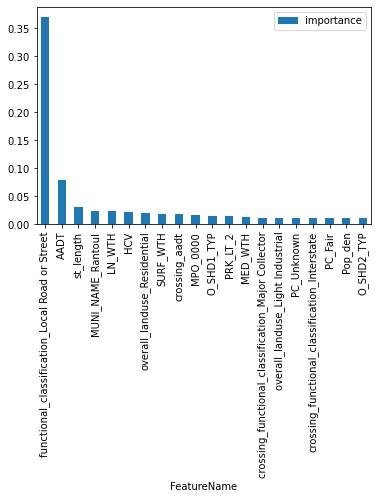

In [64]:
# feature importance
FeatureImportance = pd.DataFrame()
FeatureImportance['FeatureName'] = OHfname
FeatureImportance['importance'] = XGBmodel_fitted.feature_importances_
FeatureImportance['ABSimportance'] = abs(XGBmodel_fitted.feature_importances_)
FeatureImportance = FeatureImportance.sort_values(by='ABSimportance',ascending=False)

# Save top 10 importance features
top_features=FeatureImportance.iloc[0:20,:].FeatureName.values
# Plot top 20 importance features
FeatureImportance.iloc[0:20,:].plot.bar(x='FeatureName', y='importance', rot=90)

In [65]:
map_train = '2014-2017'
map_test = 2018

In [67]:
# # Save model in pkl
# model_str = 'XGB'
# timestr=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# model_name = model_str+str(timestr)
# segment_intersection='segment'
# model_geography='rural'
# model_type='binary'
# print(model_name)
# path=base_file_dir+'models/'+segment_intersection+'/'+model_geography+'/'+model_type+'/'
# os.makedirs(path, exist_ok=True)
# with open(path+model_name+'.pkl', 'wb') as f:
#     pickle.dump(XGBmodel_fitted, f)    

<mark> model saved as **rural_binary_XGB_trainedw2014_2017_best_thres0.378**</mark>

### Mapping

In [68]:
with open(base_file_dir+'data/interim/roadway/data_source/streets.pkl', 'rb') as f:
    streets = pickle.load(f)
# Project PCD roadway segments to epsg:3435
geo_SegmentID = geo_segmentid(streets)

# Plotting
with open(base_file_dir+'/data/processed/df_rural.pkl', 'rb') as f:
    df_rural = pickle.load(f)
df_rural_map=df_rural[['segment_id','geometry','Year','Crashes','in_urbanized_area']]
X_test_observed_map=df_rural_map.loc[X_test.index]
X_train_observed_map=df_rural_map.loc[X_train.index]

### Training data

In [69]:
map_name = model_type+'_'+'XGB'+'_'+map_train+'_predicted'+'_'+timestr
print(map_name)

binary_XGB_2014-2017_predicted_20210516-235136


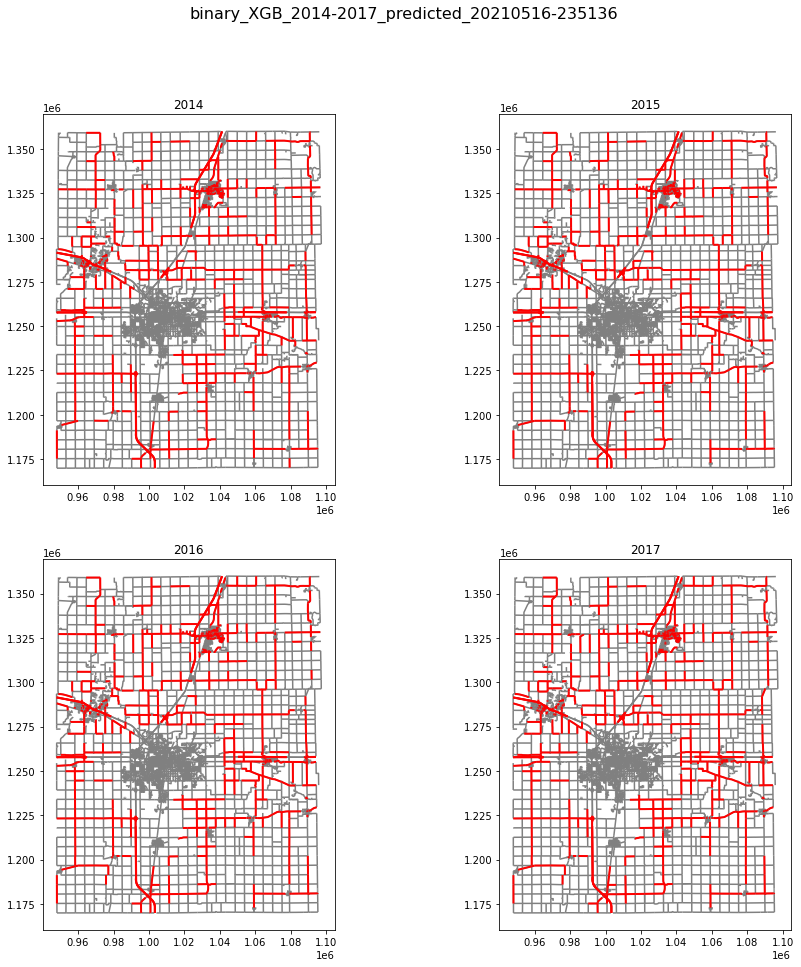

In [70]:
# Prepare plotting data
y_pred = XGBmodel_fitted.predict_proba(X_train_OHtransformed)[:,1]
y_pred_adj = [1 if y>=best_thres else 0 for y in y_pred]
prediction_result = y_pred_adj
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15,15))
axes = axes.flatten()
prediction_binary_maps (axes[0],geo_SegmentID, X_train_observed_map, prediction_result, 2014, 'segment','rural','LogReg',map_name)
prediction_binary_maps (axes[1],geo_SegmentID, X_train_observed_map, prediction_result, 2015, 'segment','rural','LogReg',map_name)
prediction_binary_maps (axes[2],geo_SegmentID, X_train_observed_map, prediction_result, 2016, 'segment','rural','LogReg',map_name)
prediction_binary_maps (axes[3],geo_SegmentID, X_train_observed_map, prediction_result, 2017, 'segment','rural','LogReg',map_name)
# Title and save figure
fig.suptitle(map_name, fontsize=16)
fig.savefig('../../reports/figures/model_results/segment_intersection/trainingdata/'+ map_name+'.png')

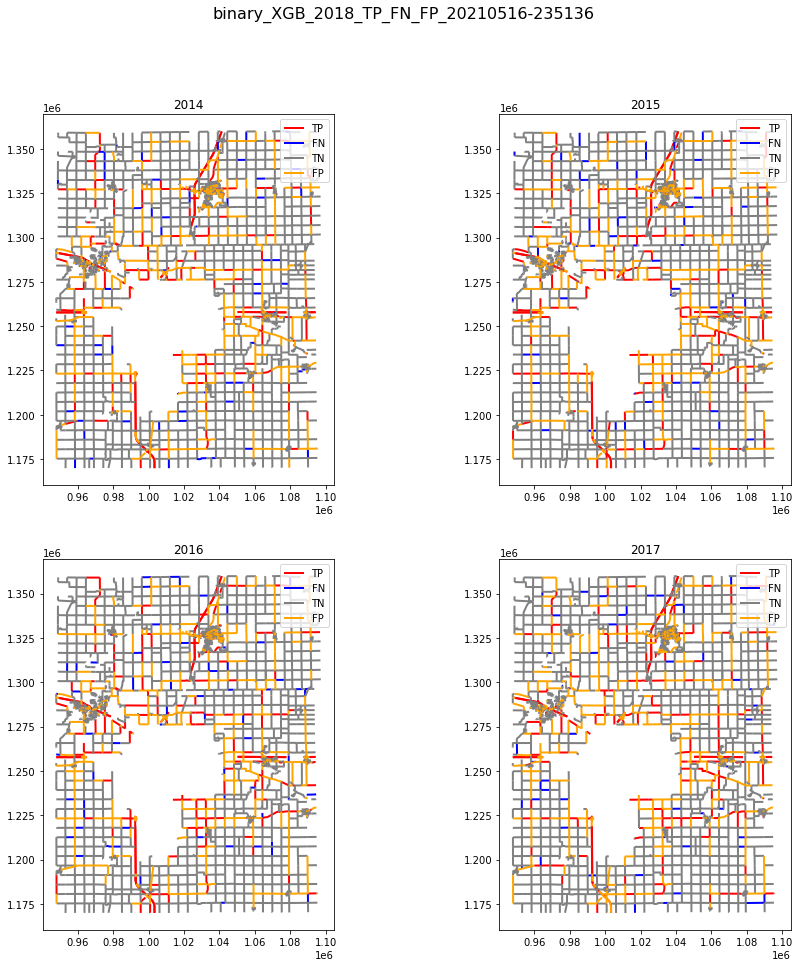

In [77]:
# Prepare plotting data
y_pred = XGBmodel_fitted.predict_proba(X_train_OHtransformed)[:,1]
y_pred_adj = [1 if y>=best_thres else 0 for y in y_pred]
prediction_result = y_pred_adj
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15,15))
axes = axes.flatten()
prediction_binary_diff_maps (axes[0],X_train_observed_map, y_train, prediction_result, 2014, segment_intersection, model_name, map_name)
prediction_binary_diff_maps (axes[1],X_train_observed_map, y_train, prediction_result, 2015, segment_intersection, model_name, map_name)
prediction_binary_diff_maps (axes[2],X_train_observed_map, y_train, prediction_result, 2016, segment_intersection, model_name, map_name)
prediction_binary_diff_maps (axes[3],X_train_observed_map, y_train, prediction_result, 2017, segment_intersection, model_name, map_name)
# Title and save figure
fig.suptitle(map_name, fontsize=16)
fig.savefig('../../reports/figures/model_results/segment_intersection/trainingdata/'+ map_name+'.png')
# red: TP, blue: FN, orange: FP

### Testing data

In [72]:
map_name = model_type +'_'+'XGB'+'_'+str(map_test)+'_predicted'+'_'+timestr
print(map_name)

binary_XGB_2018_predicted_20210516-235136


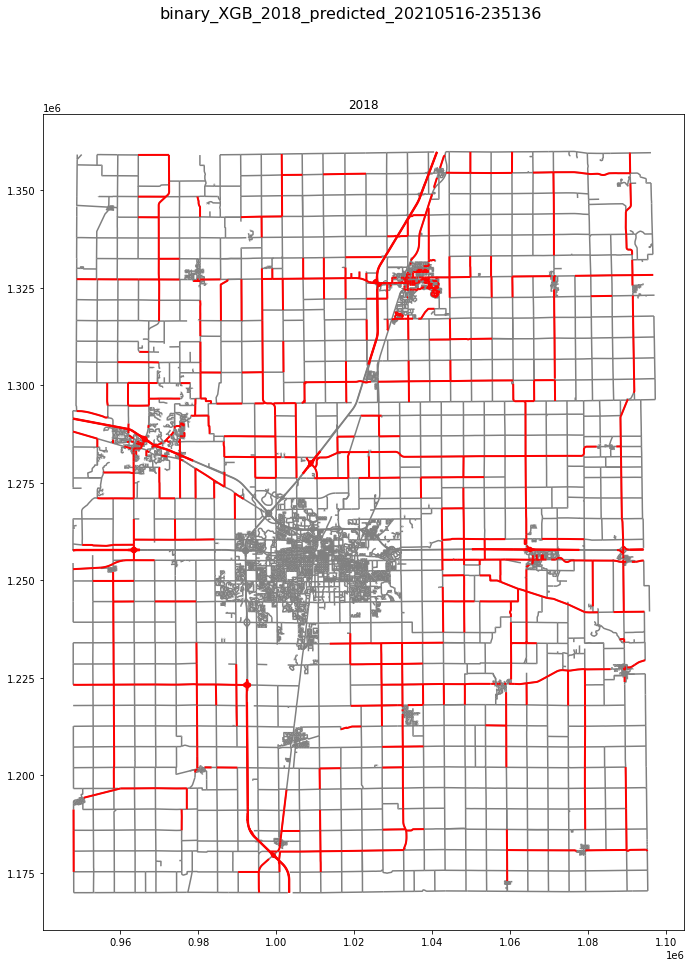

In [73]:
# Prepare plotting data

y_test_pred = XGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
# Plotting
fig, ax = plt.subplots(figsize=(15,15))
prediction_binary_maps (ax,geo_SegmentID, X_test_observed_map, y_test_pred_adj, 2018, 'segment','rural','XGB',map_name)
# Title and save figure
fig.suptitle(map_name, fontsize=16)
fig.savefig('../../reports/figures/model_results/segment_intersection/testingdata/'+map_name+'.png')

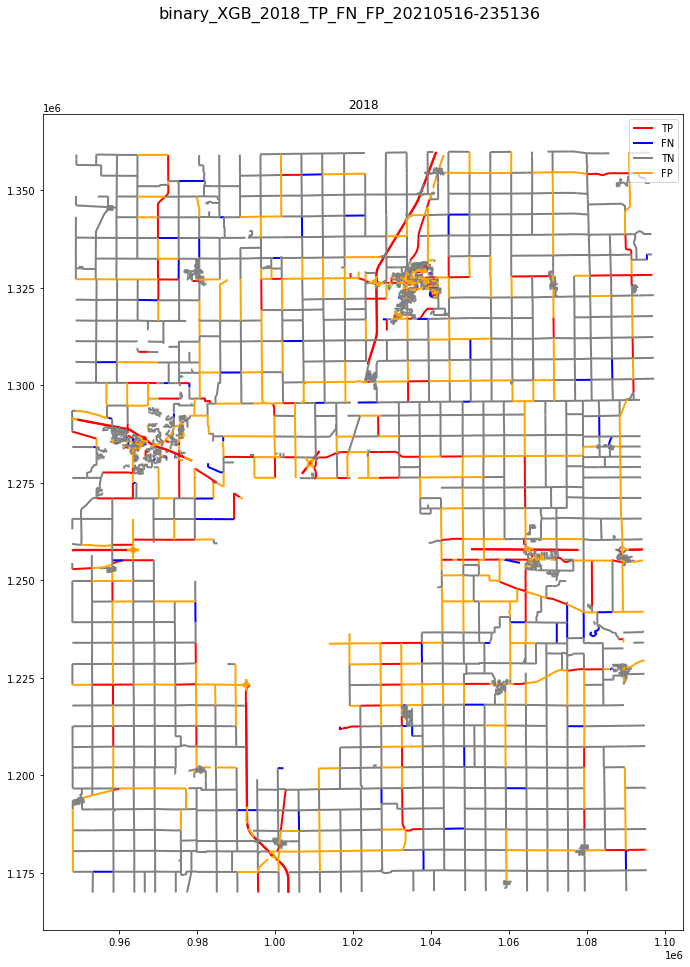

In [78]:
fig, ax = plt.subplots(figsize=(15,15))
map_name = model_type+'_'+'XGB'+'_'+str(map_test)+'_TP_FN_FP'+'_'+timestr
prediction_binary_diff_maps (ax,X_test_observed_map, y_test, y_test_pred_adj, 2018, segment_intersection, model_name, map_name)
# red: TP, blue: FN, orange: FP